<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Consumo Electrico Residencial)](#Analisis-por-grupo-de-indicadores-(consumo))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [68]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [69]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [70]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Consumo Electrico Residencial)

### Preparacion de datos

In [71]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','ConsumResidencial']]

In [72]:
df_cont = df_sel.dropna()

In [73]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4161 entries, 4380 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4161 non-null   int64  
 1   Trimestre             4161 non-null   int64  
 2   Mes                   4161 non-null   int64  
 3   Codi_Districte        4161 non-null   int64  
 4   Nom_Districte         4161 non-null   object 
 5   Codi_Barri            4161 non-null   int64  
 6   Nom_Barri             4161 non-null   object 
 7   Compraventa_Unitario  4161 non-null   float64
 8   ConsumResidencial     4161 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 325.1+ KB


In [74]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [75]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [76]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ConsumResidencial
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,18828371.0
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,15384687.0
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,14925799.0
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,13804105.0
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,13852496.0


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [77]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 5]

In [78]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [79]:
df.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-01-01,5455.166667,1.570854e+07
2019-02-01,5455.166667,1.261143e+07
2019-03-01,5455.166667,1.217628e+07
2019-04-01,5336.233333,1.111069e+07
2019-05-01,5336.233333,1.095021e+07


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2019-01-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  57 non-null     float64
 1   ConsumResidencial     57 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


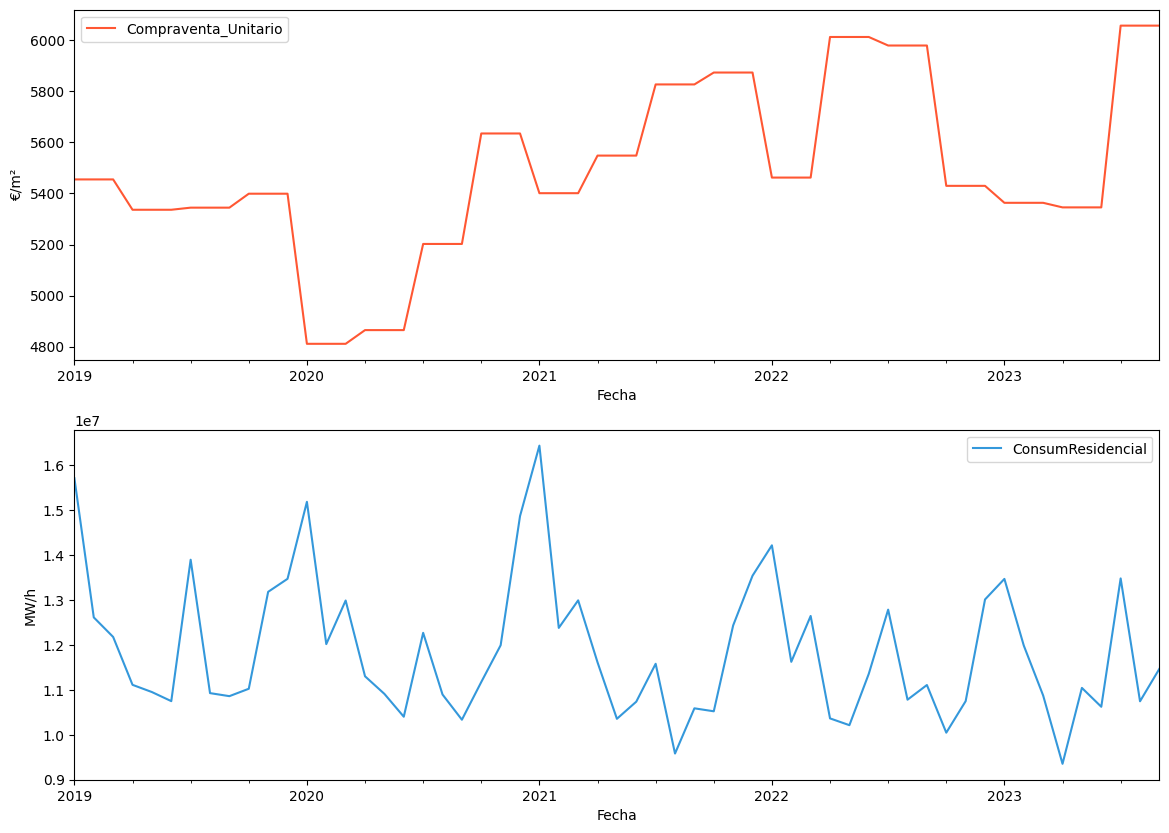

In [81]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'MW/h']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [82]:
corr=df.corr()
corr

,Compraventa_Unitario,ConsumResidencial
Compraventa_Unitario,1.000000,-0.124281
ConsumResidencial,-0.124281,1.000000


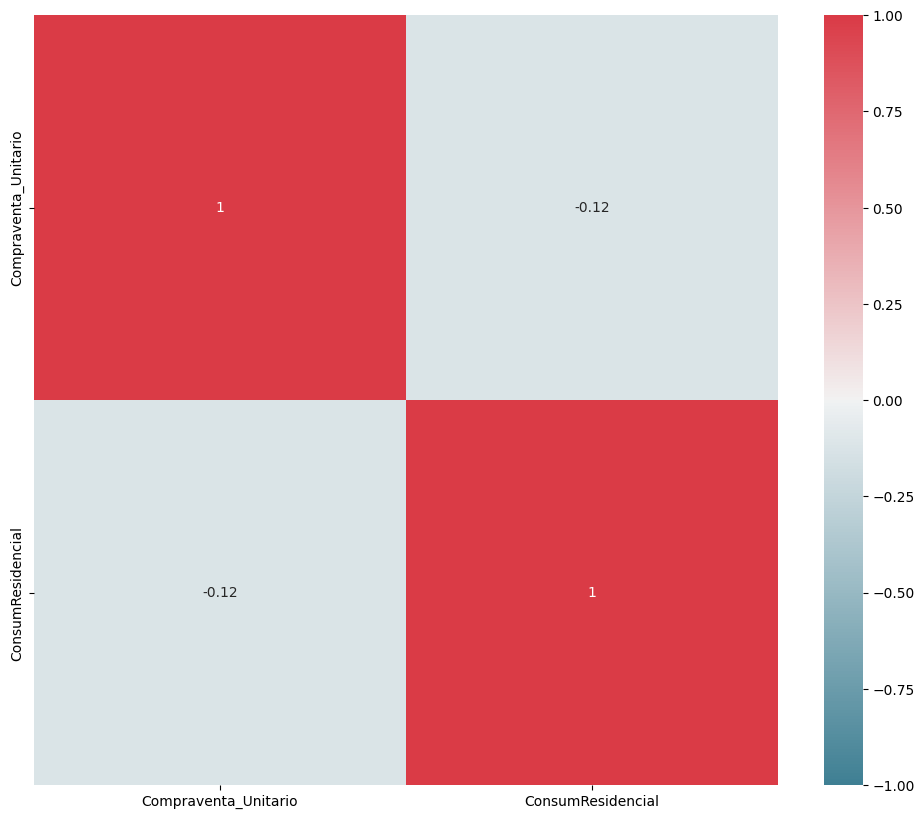

In [83]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "ConsumResidencial" es de -0.124281, lo que sugiere una correlación negativa moderada entre estas dos variables en el modelo.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola serie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de sus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [84]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(48, 2) (9, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [85]:
import statsmodels.tsa.stattools as sts

In [86]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.333200
Serie de tiempo ConsumResidencial
p-value: 0.000001


In [87]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-02-01,0.000000,-3.097110e+06
2019-03-01,0.000000,-4.351532e+05
2019-04-01,-118.933333,-1.065591e+06
2019-05-01,0.000000,-1.604777e+05
2019-06-01,0.000000,-2.022585e+05


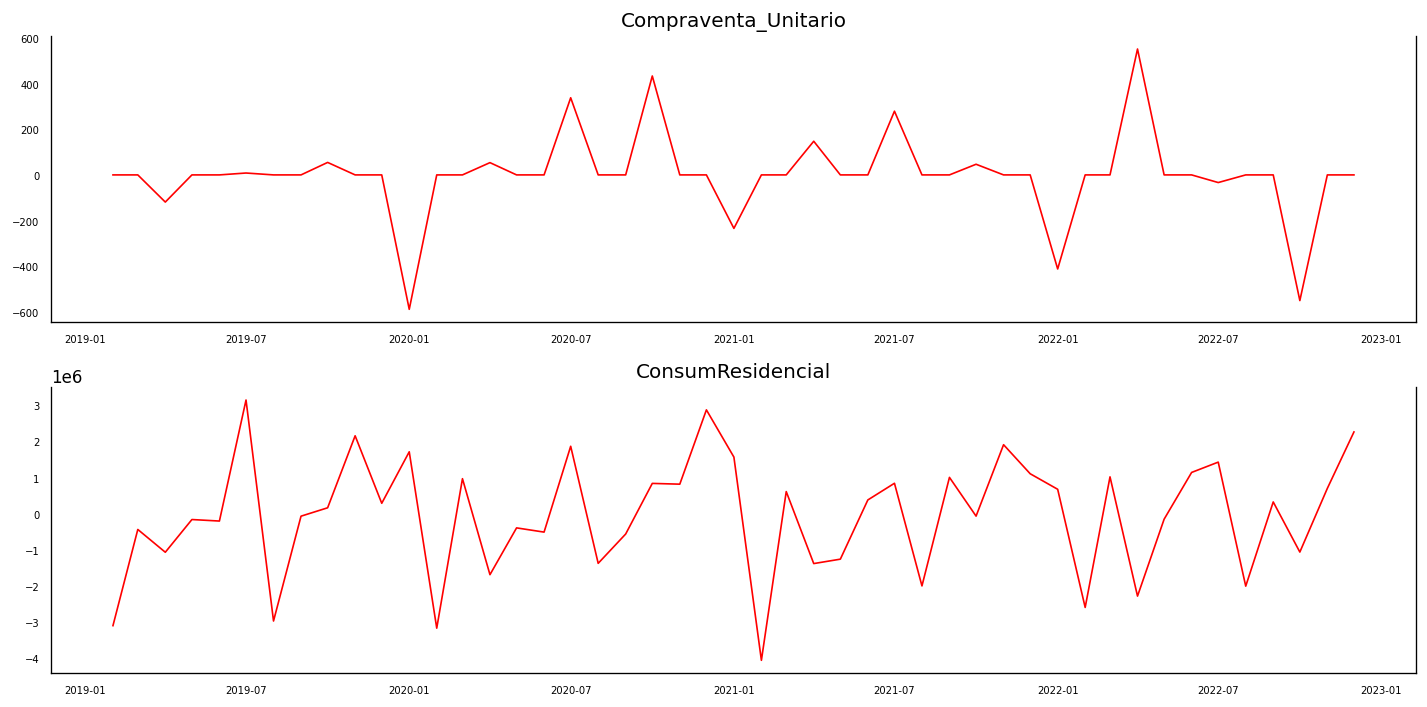

In [88]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [89]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000410
Serie de tiempo transformada Variable ConsumResidencial
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [90]:
from statsmodels.tsa.api import VAR

In [91]:
model = VAR(X_train)

#### Seleccionando el orden del modelo

In [92]:
modelsel=model.select_order(15)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,40.16,40.25,2.770e+17,40.19
1,38.83,39.10,7.288e+16,38.92
2,39.04,39.50,9.071e+16,39.19
3,39.18,39.82,1.052e+17,39.40
4,39.28,40.10,1.180e+17,39.56
5,39.41,40.40,1.370e+17,39.74
6,39.42,40.60,1.448e+17,39.82
7,38.41,39.77,5.554e+16,38.87
8,38.46,40.00,6.270e+16,38.98
9,38.16,39.88,5.133e+16,38.74


En la selección del orden VAR, el mínimo se destaca en el modelo con un orden de 15, según los criterios AIC, BIC, FPE y HQIC. Esto sugiere que un modelo de orden 15 podría ser el más adecuado para capturar la complejidad de los datos y minimizar el error de predicción.

#### Ajustando el modelo

In [93]:
res = model.fit(maxlags=15, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     15:01:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    33.4576
Nobs:                     33.0000    HQIC:                   31.5921
Log likelihood:          -537.309    FPE:                4.87310e+14
AIC:                      30.6460    Det(Omega_mle):     1.29561e+14
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                        43076.641045      8505.682066            5.064           0.000
L1.Compraventa_Unitario          0.000420         0.209804            0.002           0.998
L

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "ConsumResidencial" es de -0.930311, lo que sugiere una correlación negativa alta entre los residuos de estas dos variables en tu modelo.

In [94]:
X_train.columns

Index(['Compraventa_Unitario', 'ConsumResidencial'], dtype='object')

###### Causalidad de Granger

In [95]:
grangercaus=res.test_causality(['ConsumResidencial'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
6.788,5.858,0.039,"(15, 4)"


In [96]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['ConsumResidencial'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
5.318,5.858,0.059,"(15, 4)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [97]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train, variables = X_train.columns)

,Compraventa_Unitario_x,ConsumResidencial_x
Compraventa_Unitario_y,1.0,0.0
ConsumResidencial_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [98]:
residuals=res.resid

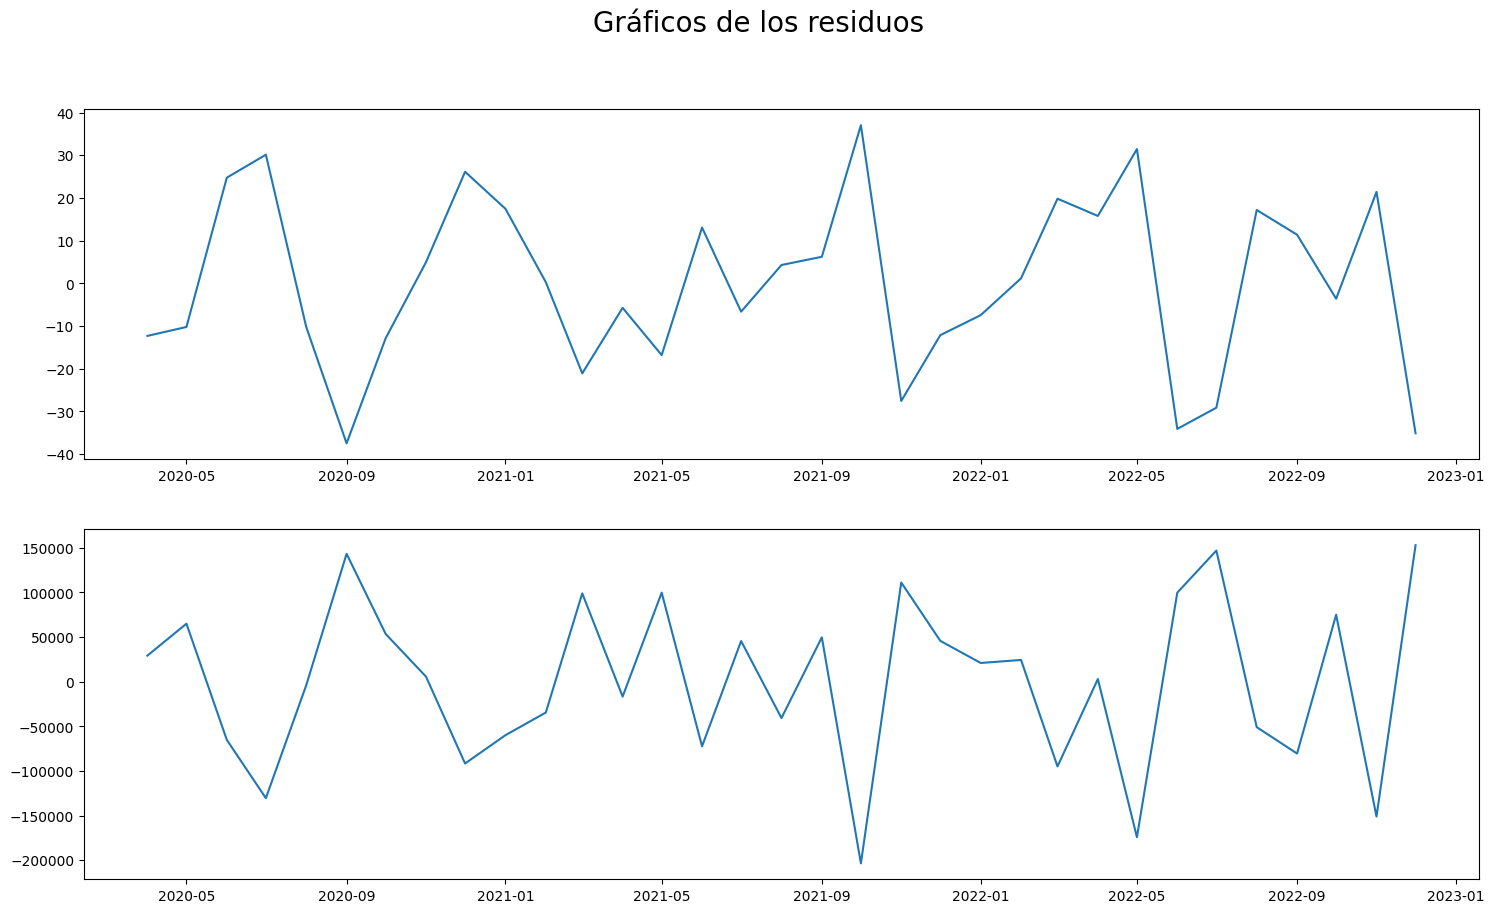

In [99]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [100]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[4.625040755237305e-06, 0.8413587077119747]

Los resultados del test ADF (Augmented Dickey-Fuller) para los residuos muestran un p-valor extremadamente bajo para la primera serie temporal (4.625040755237305e-06), lo que sugiere que podemos rechazar la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que indica que la serie es estacionaria. Sin embargo, para la segunda serie temporal, el p-valor es significativamente alto (0.8413587077119747), lo que sugiere que no podemos rechazar la hipótesis nula y que la serie temporal no es estacionaria.



###### ACF de los Residuos


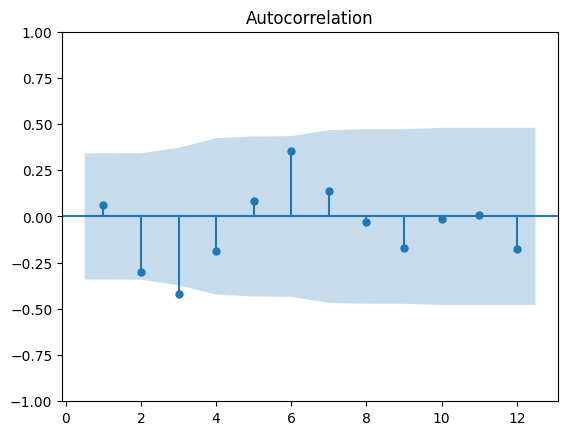

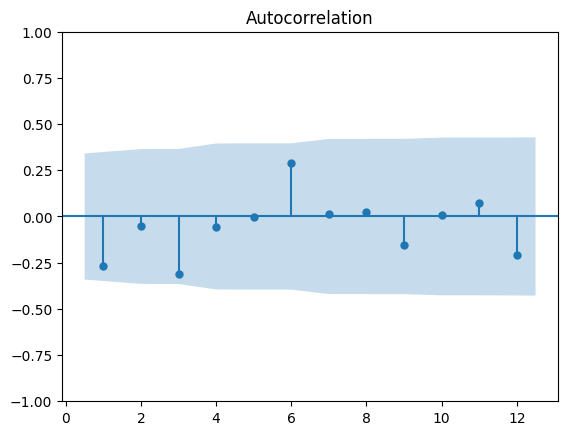

In [101]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


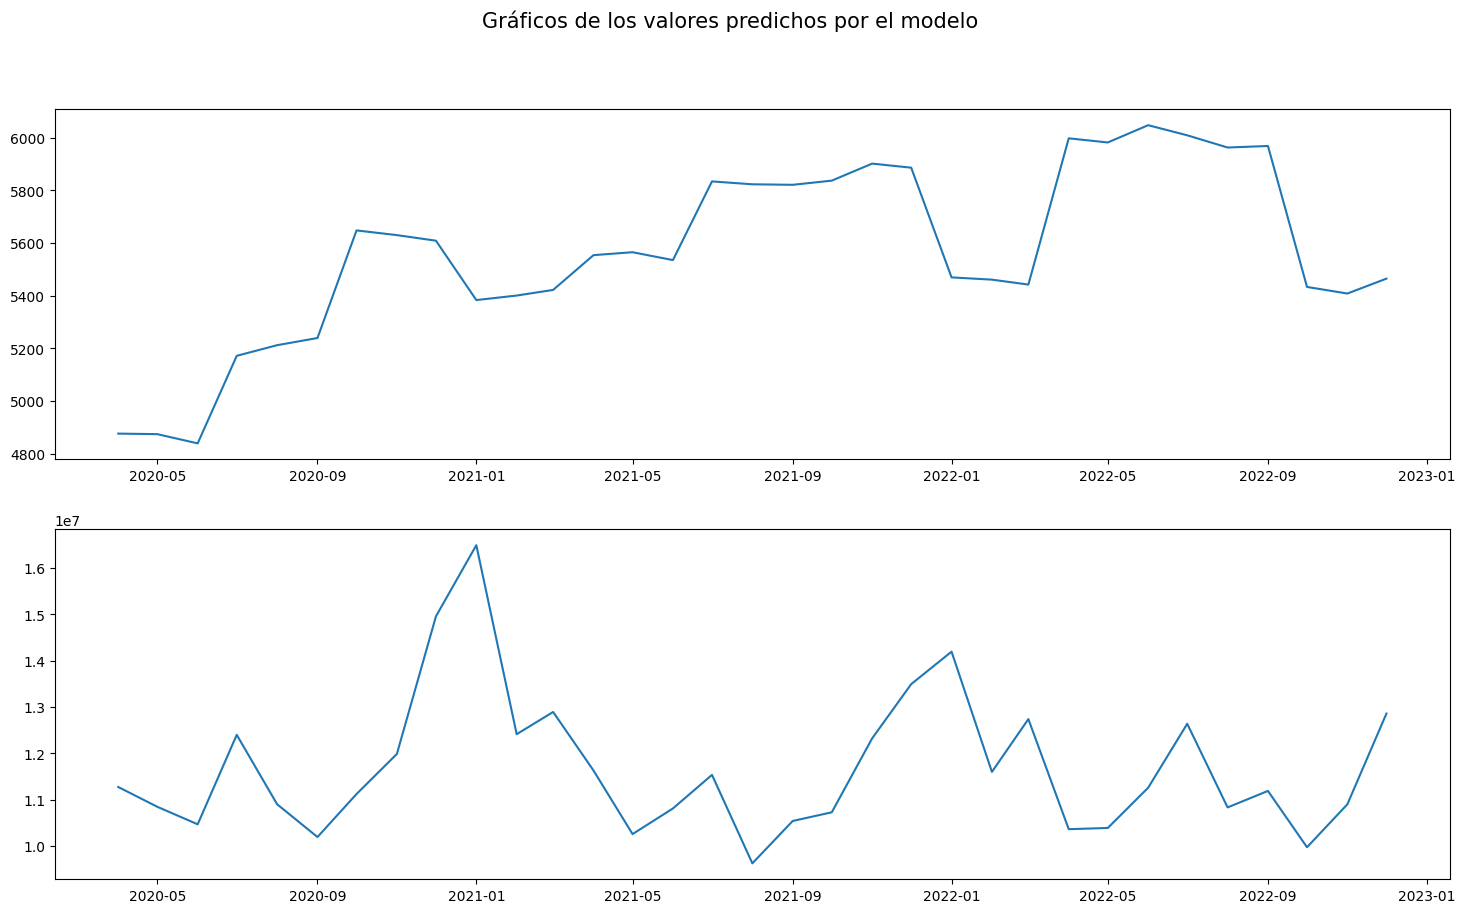

In [102]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [103]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns))
print('Predicciones:')
pred

Orden del modelo: 15
Predicciones:


,Compraventa_Unitario,ConsumResidencial
Fecha,,
2023-01-01,5657.796010,1.376645e+07
2023-02-01,5730.791104,1.068590e+07
2023-03-01,5892.972770,1.044814e+07
2023-04-01,6605.423016,1.147496e+07
2023-05-01,6130.838512,1.375774e+07
2023-06-01,6169.792650,1.227876e+07
2023-07-01,5553.995375,1.037898e+07
2023-08-01,5326.882861,9.634229e+06
2023-09-01,4980.230710,1.292746e+07


<Figure size 1200x1000 with 0 Axes>

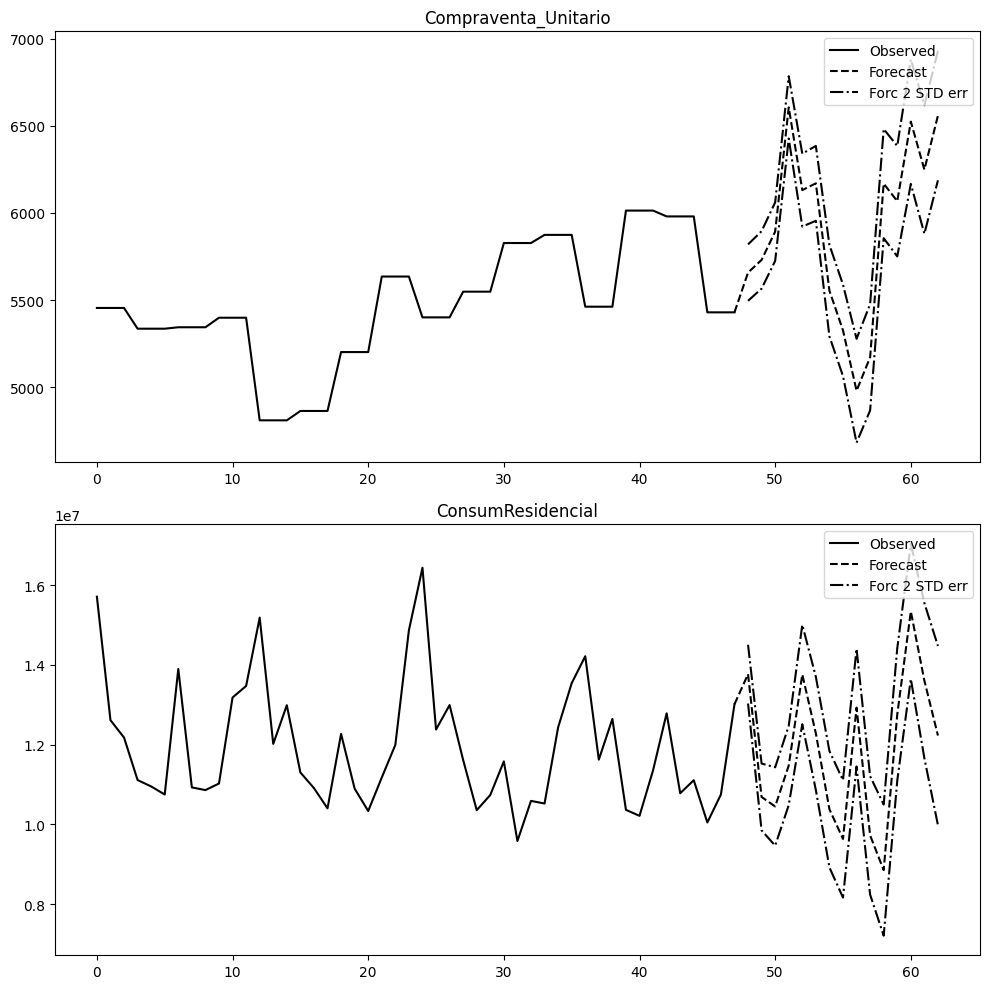

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


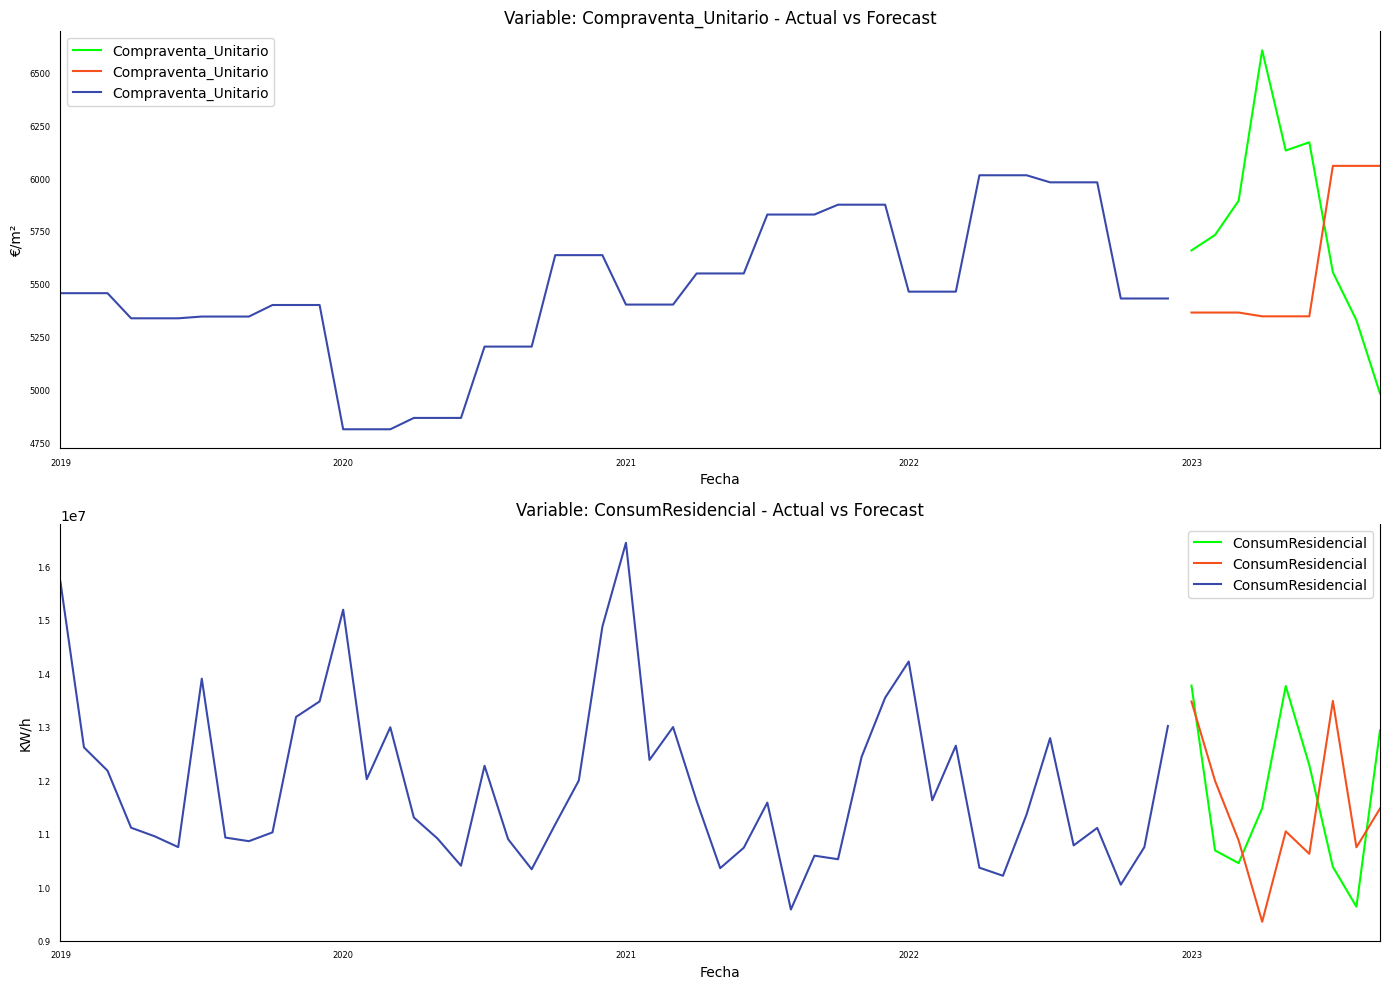

In [105]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [106]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [107]:
for i in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 592865.8674006299
MAE is : 708.1894573626191
RMSE is : 769.9778356554363
MAPE is : 12.674428950543714
R2 is : -4.386876167240151

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 3283072054842.9165
MAE is : 1576203.3050672754
RMSE is : 1811924.958391742
MAPE is : 13.987922411436216
R2 is : -1.0303044577035907



Los resultados de la evaluación muestran un desempeño deficiente en ambos modelos. Para la variable "Compraventa_Unitario", el error cuadrático medio (MSE) y el error absoluto medio (MAE) son muy altos, lo que indica que el modelo no se ajusta bien a los datos. Además, el coeficiente de determinación (R2) es negativo, lo que sugiere que el modelo no explica la variabilidad de los datos y puede estar sobreajustado.

Para la variable "ConsumResidencial", los resultados son aún peores, con valores extremadamente altos de MSE, MAE y RMSE. Esto indica que el modelo no es capaz de capturar la estructura de la serie temporal y realiza predicciones muy inexactas. El R2 negativo confirma esta mala calidad de ajuste, indicando que el modelo no es útil para explicar la variabilidad en los datos de "ConsumResidencial".

In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 788455.747262319
Root mean squared error: 1281224.5407634026


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [109]:
!pip install pmdarima

#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [110]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(48, 2) (9, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [111]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.333200
Serie de tiempo ConsumResidencial
p-value: 0.000001


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [112]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-02-01,0.000000,-3.097110e+06
2019-03-01,0.000000,-4.351532e+05
2019-04-01,-118.933333,-1.065591e+06
2019-05-01,0.000000,-1.604777e+05
2019-06-01,0.000000,-2.022585e+05


In [113]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000410
Serie de tiempo transformada Variable ConsumResidencial
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [114]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [115]:
cointegration_test(X_train[['Compraventa_Unitario','ConsumResidencial']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  7.08      > 12.3212   =>   False
ConsumResidencial >  0.29      > 4.1296    =>   False


Para la variable "Compraventa_Unitario", el valor estadístico del test es 7.08, y el valor crítico en el nivel de confianza del 95% es 12.3212. Como el valor estadístico es menor que el valor crítico, no hay suficiente evidencia para rechazar la hipótesis nula de no cointegración. Por lo tanto, se concluye que no hay evidencia de cointegración para esta variable.

Para la variable "ConsumResidencial", el valor estadístico del test es 0.29, y el valor crítico en el nivel de confianza del 95% es 4.1296. Al igual que en el caso anterior, como el valor estadístico es menor que el valor crítico, no hay suficiente evidencia para rechazar la hipótesis nula de no cointegración. Por lo tanto, se concluye que no hay evidencia de cointegración para esta variable.

Si las variables en un modelo VARMAX no están cointegradas, significa que no comparten una relación a largo plazo y pueden tener comportamientos divergentes en el tiempo. Esto puede tener varias repercusiones para el modelo VARMAX:

- Modelado inadecuado de las relaciones a largo plazo

- Menor capacidad predictiva

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [116]:
import pmdarima as pm

In [117]:

pq = []
for name in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=627.892, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=629.892, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=629.892, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=625.892, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=631.836, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.334 seconds
optimal order for:Compraventa_Unitario is: (0, 1, 0) 


Searching order of p and q for : ConsumResidencial
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1703.298, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1674.372, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1517.996, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1513.982, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0]   

#####Seleccion del modelo

In [118]:
pq

[(0, 1, 0), (2, 0, 1)]

Para la serie temporal de compraventa unitario

- *p = 0:* No hay términos autorregresivos.
- *d = 1:* Se aplica una diferencia de orden 1 para hacer estacionaria la serie.
- *q = 0:* No hay términos de promedio móvil.

Para la serie temporal de consumo electrico residencial

- *p = 2:* Se incluyen términos autorregresivos de orden 2.
- *d = 0:* No es necesario aplicar diferenciación, ya que la serie original es estacionaria.
- *q = 1:* Se incluye un término de promedio móvil de orden 1.

In [119]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [120]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [121]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE ConsumResidencial'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train[['Compraventa_Unitario', 'ConsumResidencial']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 9)
        inv_res =  inv_res = inverse_diff(df[['Compraventa_Unitario',  'ConsumResidencial']],result)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Pmrmse = np.sqrt(metrics.mean_squared_error(X_test['ConsumResidencial'], inv_res.ConsumResidencial))

        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Pmrmse]


Grid Search Started
 Running for (2, 0, 1)


In [122]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE ConsumResidencial'] )

,p,q,RMSE Compraventa_Unitario,RMSE ConsumResidencial
0,2.0,1.0,30839.636453,6.794047e+07


#### Pronósticos a futuro


In [127]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','ConsumResidencial']], order=(2,1)).fit(disp=False)
result = model.forecast(steps = 9)

In [128]:
result

,Compraventa_Unitario,ConsumResidencial
2023-01-01,-71.684689,-601252.888511
2023-02-01,-99.816339,-34481.369214
2023-03-01,-14.503978,-307687.216530
2023-04-01,-6.087118,-64619.052381
2023-05-01,4.739699,-79262.035249
2023-06-01,-0.052446,-44918.767667
2023-07-01,-1.180405,-59364.559905
2023-08-01,-2.629206,-59294.973714
2023-09-01,-2.590197,-63051.437944


In [129]:
res = inverse_diff(df[['Compraventa_Unitario', 'ConsumResidencial']],result,False)

In [130]:
res

,Compraventa_Unitario,ConsumResidencial
2023-01-01,5986.398644,1.086698e+07
2023-02-01,5886.582306,1.083250e+07
2023-03-01,5872.078327,1.052482e+07
2023-04-01,5865.991209,1.046020e+07
2023-05-01,5870.730908,1.038093e+07
2023-06-01,5870.678462,1.033602e+07
2023-07-01,5869.498057,1.027665e+07
2023-08-01,5866.868851,1.021736e+07
2023-09-01,5864.278654,1.015431e+07


#### Invertiendo la transformacion de los pronosticos a la escala original

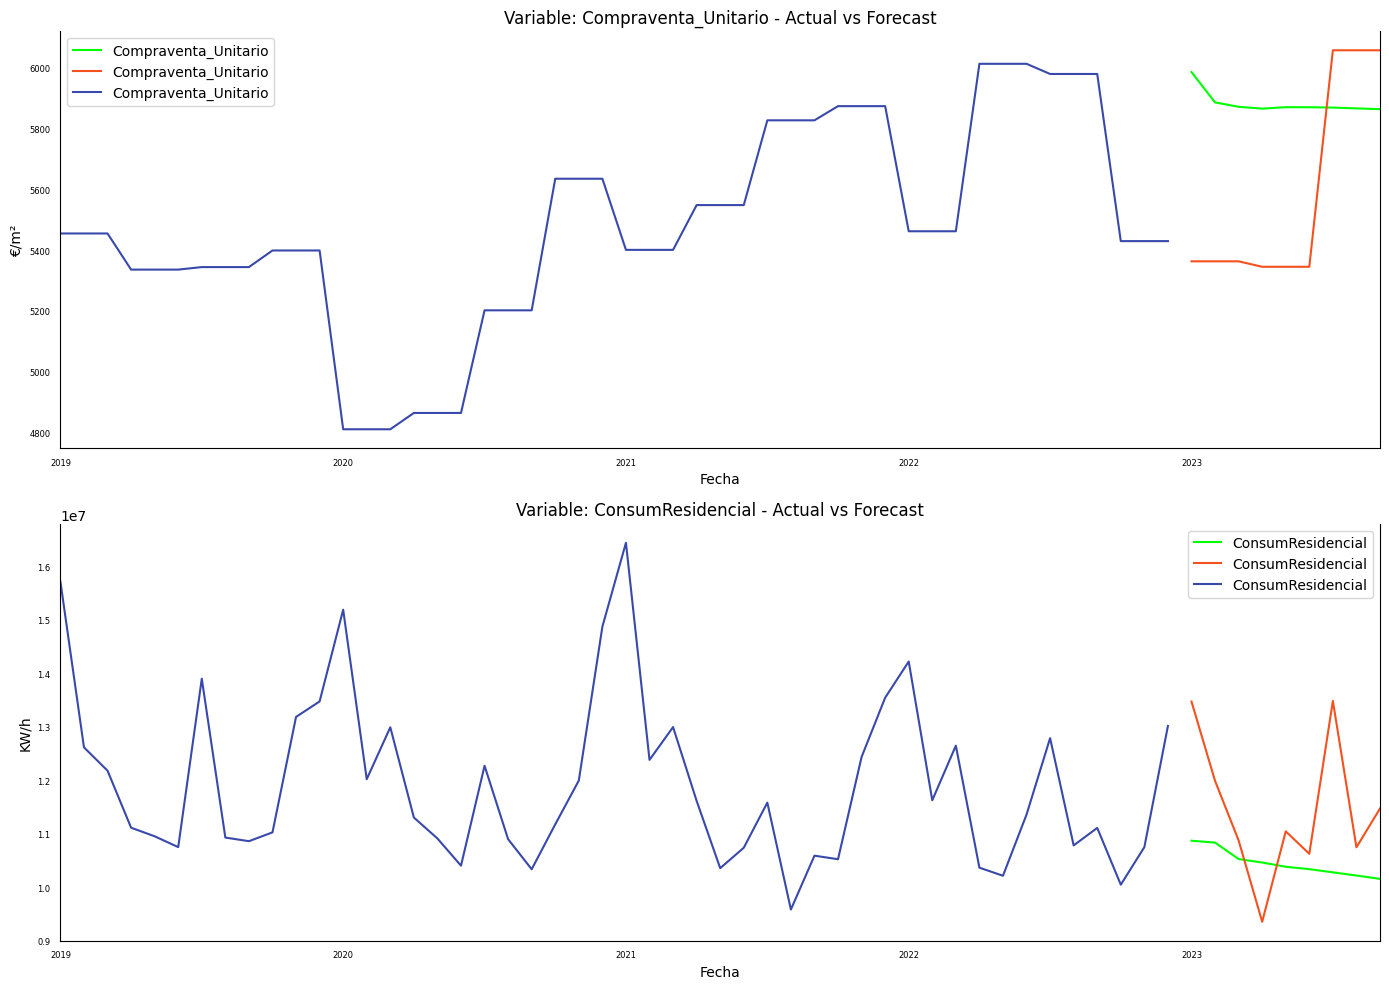

In [132]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [133]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [135]:
for i in ['Compraventa_Unitario','ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 205833.51332155068
MAE is : 422.1126992851305
RMSE is : 453.68878465480134
MAPE is : 7.744803919539363
R2 is : -0.8702369427887753

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 2468859819458.8643
MAE is : 1244559.6339671
RMSE is : 1571260.5829266082
MAPE is : 10.30933825181249
R2 is : -0.5267825418264984



Compraventa_Unitario: El modelo tiene un error cuadrático medio (MSE) muy alto, lo que sugiere una gran discrepancia entre los valores predichos y los observados. El error absoluto medio (MAE) y el error cuadrático medio (RMSE) también son elevados, indicando una falta de precisión en las predicciones. El coeficiente de determinación (R2) negativo sugiere que el modelo no explica la variabilidad de los datos y puede estar ajustando de manera incorrecta.

ConsumResidencial: Similarmente, el modelo para esta serie muestra un desempeño insatisfactorio. El MSE y el MAPE son extremadamente altos, lo que sugiere una gran discrepancia y errores significativos en las predicciones. El R2 negativo indica una falta de ajuste del modelo a los datos observados.

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 622490.8733331925
Root mean squared error: 1111049.0595136601


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Sarrià-Sant Gervasi** de Barcelona entre las dos series temporales de Compraventa_Unitario y consumo electrico residencial tenemos que:

- Se ha comprobado que las variables tienen correlación negativa moderada.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, en el primer orden de diferenciacion lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede predecir las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado negativo, lo que significa que las series no estan relacionadas en el tiempo y que serie mas acosnsejable un modelo VAR.

Ambos modelos no obtienen buenos resultados. El hecho de que la serie temporal sea relativamente corta, puede tener bastante que ver.

